# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
from torchvision import transforms
import numpy as np
from PIL import Image
import torchvision.models as models
import torch
from torch import nn
import copy
import tqdm
import json
import time
from collections import defaultdict
from torch.optim import lr_scheduler
from torchvision.datasets import MNIST
from torch.utils.data import WeightedRandomSampler,SubsetRandomSampler
from efficientnet_pytorch import EfficientNet

from torchvision.datasets import MNIST
from sklearn.utils import class_weight
import warnings; warnings.simplefilter('ignore')
from sklearn.utils import shuffle
from albumentations.pytorch import ToTensorV2
import albumentations as A
import gc
from patchify import patchify
from torchsummary import summary
import statistics as stat

#User defined functions and classes goes below:######
from config import config
from ldctdataloader import Generate_data
from get_model import get_model
from train_val import train_model,train_self_supervised
from utility import get_scheduler, get_loss_fn,save_fold_results,fix_seed
import tifffile
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

# Config & Seed value

In [2]:
fix_seed(config) # This will fix the seed and generate unique model name
print(config)

{'random_seed': 48, 'IM_W': 512, 'IM_H': 512, 'Batch': 1, 'device': device(type='cuda'), 'LR': 0.0001, 'epoch': 100, 'model': 'EffSwinKAT', 'imgnet_pretrained': True, 'xrv_pretrained': False, 'loss_fn': 'MSE', 'scheduler_warmup': 1, 'scheduler': 'cos', 'scheduler_step': 15, 'kfold': 1, 'weight_decay': 0, 'huber_delta': 1.2, 'wandb': True, 'multi_channel_input': False, 'multi_channel': 2, 'gauss_kernel': 5, 'only_normalized': False, 'self-supervised': False, 'current_label': 'stdev', 'multi-task': False, 'krocc_loss': False, 'rank_mse': False, 'discordant_penalty': False, 'normalized_output': False, 'add_KL': False, 'KL_weight': 0.01, 'SimCLR_temperature': 0.5, 'SimCLR_pretraining': False, 'Freeze_before_FC': False, 'projection_head': 128, 'tcl_pretraining': False, 'all_data_training': False, 'kadid_pretraining': False, 'mayoct_pretraining': False, 'mayoct_classification_pretraining': False, 'mayoct_path': '../mayoct_full_reference_preprocessed/train/', 'experiment_name': 'TFKTV2_infere

In [3]:
import os
import json

# Load the list of test images from the specified directory
test_image_list = os.listdir('sample_images/images')

# Display the total number of images in the test set
print("Total number of images in test set: ", len(test_image_list))

# If test IQA labels are required, you can load them here
with open('sample_images/test.json', "r") as f:
    test_data_iqa_labels = json.load(f)  # This has the label information

# Extract test IQA labels
test_iqa_labels = [test_data_iqa_labels[test_img] for test_img in test_image_list]



Total number of images in test set:  4


In [4]:
test_set_result=[]
model=get_model(config)
model.load_state_dict(torch.load('saved_models/EffSwinKAT_16_1'))

Training w/ EffSwinKAT


<All keys matched successfully>

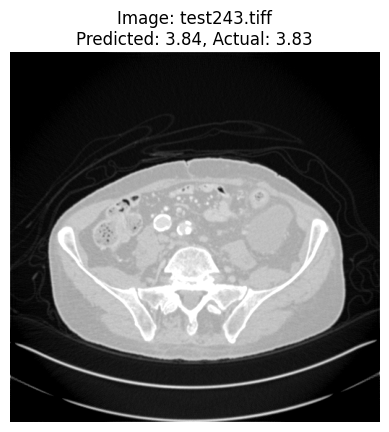

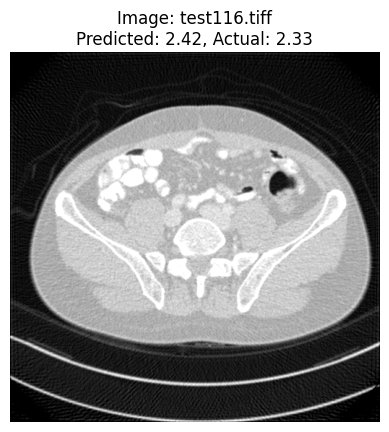

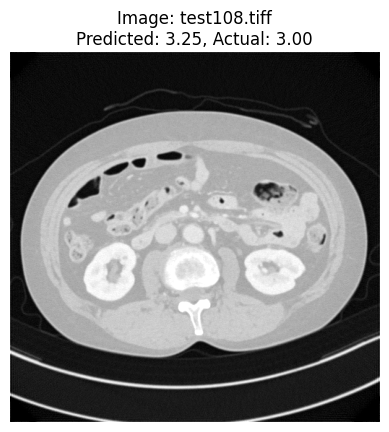

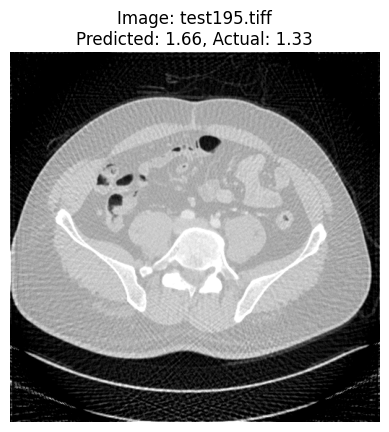

Predicted vs Actual IQA Scores:
test243.tiff: Predicted: 3.84, Actual: 3.83
test116.tiff: Predicted: 2.42, Actual: 2.33
test108.tiff: Predicted: 3.25, Actual: 3.00
test195.tiff: Predicted: 1.66, Actual: 1.33


In [5]:
# Store predictions and ground truth
predicted_vs_actual = []

model.eval()
for cur_test_img in test_image_list:
    # Read and preprocess the image
    image = tifffile.imread('sample_images/images/' + cur_test_img)
    image_tensor = torch.tensor(np.expand_dims(np.expand_dims(image, axis=0), axis=0))
    image_tensor = image_tensor.to(config['device'])
    image_tensor = (image_tensor - torch.min(image_tensor)) / (torch.max(image_tensor) - torch.min(image_tensor))  # Min-max normalization

    # Predict the IQA score
    prediction = model(image_tensor)
    prediction = float(prediction.detach().cpu().numpy()[0][0])

    # Ground truth IQA score
    actual_value = test_data_iqa_labels[cur_test_img]

    # Append to results list
    predicted_vs_actual.append((cur_test_img, prediction, actual_value))

    # Display the image with predicted and actual IQA scores
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(f"Image: {cur_test_img}\nPredicted: {prediction:.2f}, Actual: {actual_value:.2f}")
    plt.axis('off')
    plt.show()

# Display all predicted vs actual values
print("Predicted vs Actual IQA Scores:")
for img_name, pred, actual in predicted_vs_actual:
    print(f"{img_name}: Predicted: {pred:.2f}, Actual: {actual:.2f}")
